# Finding the shortest path in an amusement park

## Section 1 : Setup 

In [ ]:
# import 
import cv2
import tkinter as tk
from tkinter.simpledialog import askstring

In [1]:


#------------------------------------------------------------------------------------------------------------------

all_points = {}

original_image = cv2.imread('Map.JPG')
image_copy = original_image.copy()
cv2.imwrite('Map_with_points.JPG', image_copy)

#------------------------------------------------------------------------------------------------------------------

def add_point(event, x, y, flags, param):
    global points, all_points
    if event == cv2.EVENT_RBUTTONDOWN:
        # Store the point in the original image coordinates
        original_x = int((x + x_offset) / current_zoom)
        original_y = int((y + y_offset) / current_zoom)
        
        # Create a Tkinter root window (hidden)
        root = tk.Tk()
        root.withdraw()
        
        # Display an input dialog to enter the name for the point
        point_name = askstring("Point Name", "Enter a name for the point:")
        
        # Check if a name was entered
        if point_name:
            # Store the point in the dictionaries
            points[point_name] = (original_x,original_y)
            all_points[point_name] = (original_x,original_y)

        # Destroy the root window
        root.destroy()
        update_display()

#------------------------------------------------------------------------------------------------------------------

def zoom_in():
    global current_zoom
    if current_zoom < max_zoom:
        current_zoom *= zoom_factor
        update_display()

def zoom_out():
    global current_zoom
    if current_zoom > min_zoom:
        current_zoom /= zoom_factor
        update_display()

#------------------------------------------------------------------------------------------------------------------

def move(direction):
    global x_offset, y_offset
    if direction == 'up':
        y_offset -= move_step
    elif direction == 'down':
        y_offset += move_step
    elif direction == 'left':
        x_offset -= move_step
    elif direction == 'right':
        x_offset += move_step
    update_display()

#------------------------------------------------------------------------------------------------------------------

def update_display():
    global image, x_offset, y_offset, points
    zoomed_image = cv2.resize(original_image.copy(), None, fx=current_zoom, fy=current_zoom, interpolation=cv2.INTER_LINEAR)
    image = zoomed_image.copy()
    
    # Calculate the maximum allowable offsets to avoid going out of bounds
    max_x_offset = max(image.shape[1] - original_image.shape[1], 0)
    max_y_offset = max(image.shape[0] - original_image.shape[0], 0)
    
    # Limit x_offset and y_offset to stay within bounds
    x_offset = max(0, min(x_offset, max_x_offset))
    y_offset = max(0, min(y_offset, max_y_offset))
    
    # Apply offsets to simulate movement
    image = image[y_offset:y_offset + original_image.shape[0], x_offset:x_offset + original_image.shape[1]]
    
    # Draw the points on the zoomed image at their original positions
    for point_name, point in points.items():
        x, y = point
        zoomed_x = int((x - x_offset) * current_zoom)
        zoomed_y = int((y - y_offset) * current_zoom)
        cv2.circle(image, (zoomed_x, zoomed_y), 5, (0, 0, 255), -1)
    
    cv2.imshow('Image with Points', image)

#------------------------------------------------------------------------------------------------------------------

boo = True
while boo :  

    points = {}

    #------------------------------------------------------------------------------------------------------------------

    # Zoom parameters
    zoom_factor = 1.2  # You can adjust the zoom factor
    current_zoom = 1.0
    max_zoom = 4.0
    min_zoom = 0.2

    # Movement parameters
    x_offset = 0
    y_offset = 0
    move_step = 50  # You can adjust the movement step size

    #------------------------------------------------------------------------------------------------------------------

    # Load your JPEG image
    original_image = cv2.imread('Map_with_points.JPG')
    image = original_image.copy()

    #------------------------------------------------------------------------------------------------------------------

    # Create a window and set the mouse callback function
    cv2.namedWindow('Image with Points')
    cv2.setMouseCallback('Image with Points', add_point)

    #------------------------------------------------------------------------------------------------------------------

    while True:
        cv2.imshow('Image with Points', image)

        # Wait for user input and perform zoom, movement, or exit
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('+'):
            zoom_in()
        elif key == ord('-'):
            zoom_out()
        elif key == ord('8'):
            move('up')
        elif key == ord('2'):
            move('down')
        elif key == ord('4'):
            move('left')
        elif key == ord('6'):
            move('right')
        elif key == ord('y'):
            boo = False 
            break 

    #------------------------------------------------------------------------------------------------------------------

    # Save the final image with points
    final_image_with_points = original_image.copy()
    for point_name, point in points.items():
        x, y = point
        cv2.circle(final_image_with_points, (x, y), 5, (255, 0, 0), -1)
    cv2.imwrite('Map_with_points.JPG', final_image_with_points)

    #------------------------------------------------------------------------------------------------------------------

    # Save the points to a file or use them as needed
    print("Clicked points:", points)

    cv2.destroyAllWindows()

    #------------------------------------------------------------------------------------------------------------------

print()
for name, location in all_points.items():
    print(f"Name: {name}, Location: {location}")

# Specify the name of the output text file
output_file = "points.txt"

# Open the file in write mode
with open(output_file, "w") as file:
    for name, location in all_points.items():
        file.write(str(name) + ';' + str(location) + '\n')


Clicked points: {'snake': (394, 254), 'lion': (237, 165), 'tiger': (713, 225), 'bat': (598, 509)}

Name: snake, Location: (394, 254)
Name: lion, Location: (237, 165)
Name: tiger, Location: (713, 225)
Name: bat, Location: (598, 509)


In [4]:
import cv2
import tkinter as tk
from tkinter.simpledialog import askstring
import subprocess

#------------------------------------------------------------------------------------------------------------------

all_curves = []
Curves = {} 

#------------------------------------------------------------------------------------------------------------------

original_image = cv2.imread('Map_with_points.JPG')
image_copy = original_image.copy()
cv2.imwrite('Map_with_curves.JPG', image_copy)

#------------------------------------------------------------------------------------------------------------------

boo = True
drawing = False  # True if mouse button is pressed
points = []  # Points of the current curve
count = 1 

def calculate_curve_length(points):
    # Calculate the length of the curve using numerical integration
    length = 0
    for i in range(1, len(points)):
        x1, y1 = points[i - 1]
        x2, y2 = points[i]
        segment_length = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        length += segment_length
    return length

def draw_curve(event, x, y, flags, param):
    global drawing, points, image_copy, count

    line = []

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        points = [(x, y)]

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            points.append((x, y))
            for i in range(1, len(points)):
                cv2.line(image_copy, points[i - 1], points[i], (0, 0, 255), 2)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

        for Node in ["start", "end"]: 

            # Create a Tkinter root window (hidden)
            root = tk.Tk()
            root.withdraw()

            # Display an input dialog to enter the name for the point
            node = askstring("Point Name", "Enter a name for the " + Node + " :")

            # Check if a name was entered
            if node:
                # Store the point in the dictionaries
                line.append(node)

            # Destroy the root window
            root.destroy()
 
        name = (count, line[0], line[1])
        count += 1
        all_curves.append(points)
        Curves[name] = calculate_curve_length(points)

#------------------------------------------------------------------------------------------------------------------

# Specify the name of the text file you want to open
file_to_open = "points.txt"

# Open the text file in the default text editor
subprocess.Popen([file_to_open], shell=True)

cv2.namedWindow('Image with Curve')
cv2.setMouseCallback('Image with Curve', draw_curve)

#------------------------------------------------------------------------------------------------------------------

boo = True 
while boo:

    #------------------------------------------------------------------------------------------------------------------

    # Load your JPEG image
    image_copy = original_image.copy()

    #------------------------------------------------------------------------------------------------------------------

    while True:
        cv2.imshow('Image with Curve', image_copy)

        # Wait for user input and perform zoom, movement, or exit
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('+'):
            zoom_in()
        elif key == ord('-'):
            zoom_out()
        elif key == ord('8'):
            move('up')
        elif key == ord('2'):
            move('down')
        elif key == ord('4'):
            move('left')
        elif key == ord('6'):
            move('right')
        elif key == ord('y'):
            boo = False
            break

    #------------------------------------------------------------------------------------------------------------------

    # Save the final image with the curves
    for curve in all_curves:
        for i in range(1, len(curve)):
            cv2.line(original_image, curve[i - 1], curve[i], (255, 0, 0), 2)

    cv2.imwrite('Map_with_curves.JPG', original_image)

    #------------------------------------------------------------------------------------------------------------------

cv2.destroyAllWindows()

#------------------------------------------------------------------------------------------------------------------

for ends, length in Curves.items():
    print(f"Ends: {ends}, Length: {length}")

# Specify the name of the output text file
output_file = "curves.txt"

# Open the file in write mode
with open(output_file, "w") as file:
    for ends, length in Curves.items():
        file.write(str(ends[0]) + ';' + ends[1] + ',' + ends[2] + ';' + str(length) + '\n') 

Ends: (1, 'bat', 'snake'), Length: 404.7279481634716
Ends: (2, 'bat', 'snake'), Length: 942.466318997224
Ends: (3, 'lion', 'snake'), Length: 214.74888238242275
Ends: (4, 'tiger', 'lion'), Length: 502.0351693595027


In [12]:
import numpy as np 
import sys
from itertools import combinations

# Read node data from file
with open('points.txt', 'r') as f:
    nodes = {}
    for line in f.readlines():
        name, location_part = line.strip().split(';')
        location = location_part.strip()[1:-1].split(',')
        location = (int(location[0]), -1 * int(location[1]))  # -1 because the ref is the top left corner
        nodes[name] = location

print(nodes)

already = [] 

# Read edge data from file
with open('curves.txt', 'r') as f:
    edges = {}
    for line in f.readlines():
        num, ends_part, length = line.strip().split(';')

        length = round(float(length), 3)

        node1, node2 = ends_part.strip().split(',')

        edge = (node1,node2)
        edge_bis = (node2, node1)

        if edge not in already and edge_bis not in already : 
            edges[edge] = float(length)
            already.append(edge)

        else :
            if edge in already : 
                if length < edges[edge] : 
                    edges[edge] = length
            if edge_bis in already : 
                if length < edges[edge_bis] : 
                    edges[edge_bis] = length 

print(edges)

# Create distance matrix
names = [] 
for name in nodes.keys() : 
    names.append(name)

dists = [[0]*len(nodes) for _ in range(len(nodes))]

for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):

        edge = (names[i], names[j])
        edge_bis = (names[j], names[i])

        if edge in edges.keys() :
            dists[i][j] = edges[edge]
            dists[j][i] = edges[edge]
        elif edge_bis in edges.keys() : 
            dists[i][j] = edges[edge_bis]
            dists[j][i] = edges[edge_bis]
        else : 
            dists[i][j] = float('inf')
            dists[j][i] = float('inf')

print(dists)

{'snake': (394, -254), 'lion': (237, -165), 'tiger': (713, -225), 'bat': (598, -509)}
{('bat', 'snake'): 404.728, ('lion', 'snake'): 214.749, ('tiger', 'lion'): 502.035}
[[0, 214.749, inf, 404.728], [214.749, 0, 502.035, inf], [inf, 502.035, 0, inf], [404.728, inf, inf, 0]]


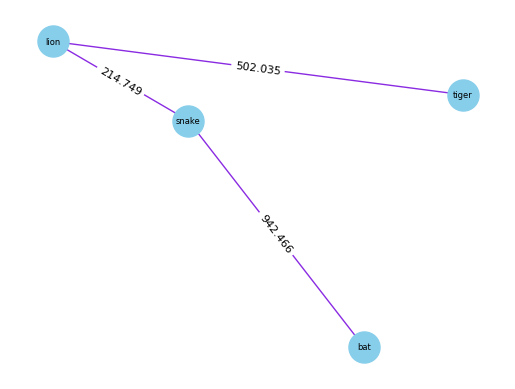

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

for name in nodes.keys() : 
    G.add_node(name, pos=nodes[name])

with open('curves.txt', 'r') as file:
    for line in file:
        if line.strip():
            num, ends_part, length = line.strip().split(';')
            length = round(float(length), 3)
            
            # Split the ends into node names
            ends = ends_part.strip().split(',')
            
            # Add edges with lengths
            G.add_edge(ends[0], ends[1], weight=length)

# Get node positions from the graph
node_positions = {node: data['pos'] for node, data in G.nodes(data=True)}

# Create the graph layout based on the node positions
position = nx.spring_layout(G, pos=node_positions, fixed=node_positions.keys())

# Create dictionaries for node and edge labels
node_labels = {node: node for node in G.nodes()}
edge_labels = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}

# Draw the nodes
nx.draw_networkx_nodes(G, position, node_color='skyblue', node_size=500)


# Draw the edges
nx.draw_networkx_edges(G, position, edge_color='blueviolet')

# Draw the labels for nodes and edges
nx.draw_networkx_labels(G, position, labels=node_labels, font_size=6, font_color='black')
nx.draw_networkx_edge_labels(G, position, edge_labels=edge_labels, font_size=8)

# Remove axis labels
plt.axis('off')

# Display the graph
plt.show()


In [ ]:
import heapq

def modified_dijkstra(graph, start, end):
    n = len(graph)
    dist = [[float('inf')] * (1<<n) for _ in range(n)]
    prev = [[-1] * (1<<n) for _ in range(n)]
    
    dist[start][1<<start] = 0
    heap = [(0, start, 1<<start)]
    
    while heap:
        d, u, mask = heapq.heappop(heap)
        
        if d != dist[u][mask]:
            continue
        
        for v in range(n):
            if graph[u][v] is None:
                continue
            
            mask2 = mask | (1<<v)
            if dist[v][mask2] > dist[u][mask] + graph[u][v]:
                dist[v][mask2] = dist[u][mask] + graph[u][v]
                prev[v][mask2] = u
                heapq.heappush(heap, (dist[v][mask2], v, mask2))
    
    return build_path(prev, end, (1<<n)-1), dist[end][(1<<n)-1]

def build_path(prev, node, mask):
    if prev[node][mask] == -1:
        return [node]
    return build_path(prev, prev[node][mask], mask^(1<<node)) + [node]

print(modified_dijkstra(dists, 0, 0))


In [ ]:
import itertools
import random
import sys


def held_karp(dists):
    """
    Implementation of Held-Karp, an algorithm that solves the Traveling
    Salesman Problem using dynamic programming with memoization.

    Parameters:
        dists: distance matrix

    Returns:
        A tuple, (cost, path).
    """
    n = len(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

print(held_karp(dists))

In [ ]:
import networkx as nx 

final = nx.DiGraph()

for node in G.nodes() : 
    final.add_node(node)

for i in range (len(walks)-1): 
    final.add_edge(walks[i], walks[i+1])

# Create dictionaries for node and edge labels
node_labels = {node: node for node in final.nodes()}

# Draw the nodes
nx.draw_networkx_nodes(final, position, node_color='skyblue', node_size=500)

# Draw the edges
nx.draw_networkx_edges(final, position, edge_color='blueviolet')

# Draw the labels for nodes and edges
nx.draw_networkx_labels(final, position, labels=node_labels, font_size=6, font_color='black')

# Remove axis labels
plt.axis('off')

# Display the graph
plt.show()